In [4]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import os
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
import torch
import random
from sklearn.cluster import KMeans

import sys
import os
sys.path.append(os.path.abspath(".."))
import src.HiddenMarkovOT as HiddenMarkovOT
import src.utils.clustering as clustering
import src.plotting as plotting

def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
    return

seed_everything(42)


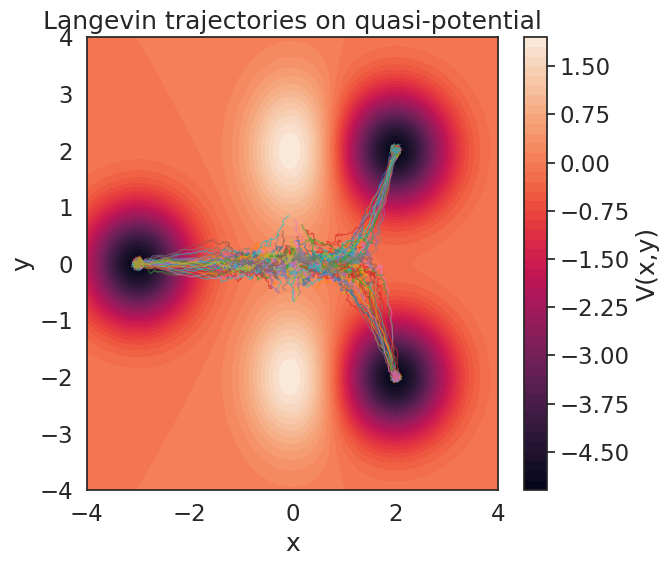

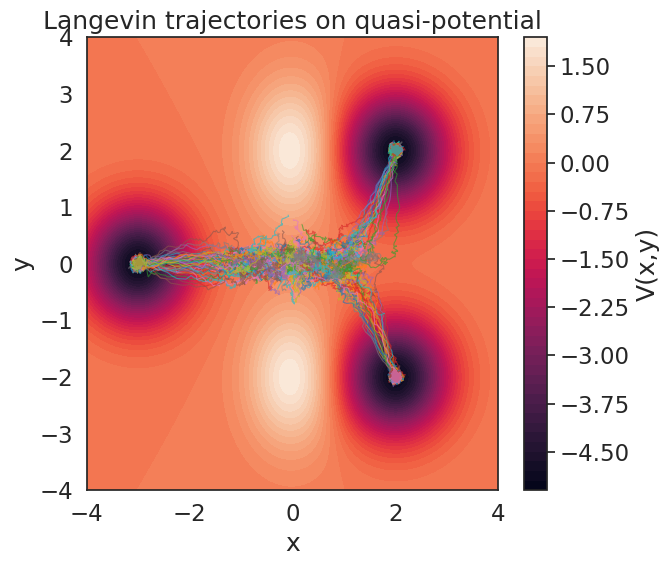

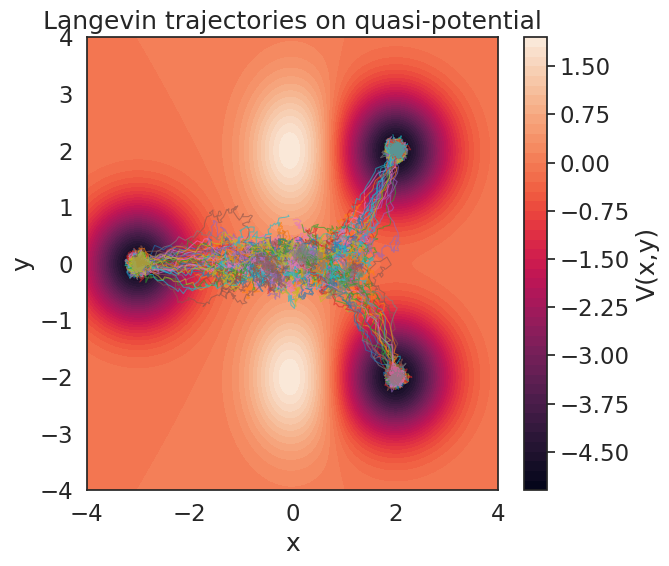

In [5]:
import src.utils.waddington.simulation as simu

# --- example usage ------------------------------------------
datasets = simu.generate_datasets_for_noises(
    [0.01, 0.02, 0.05],
    num_traj=300,
    N_steps=400,
    dt=0.02,
    snap_times=(0,200,399),
    seed=42,
    plot_original=True
)



==== D = 0.002 ====


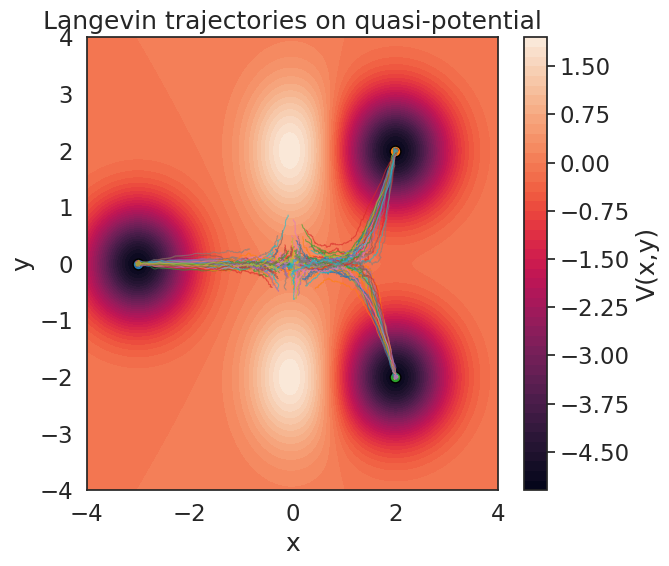

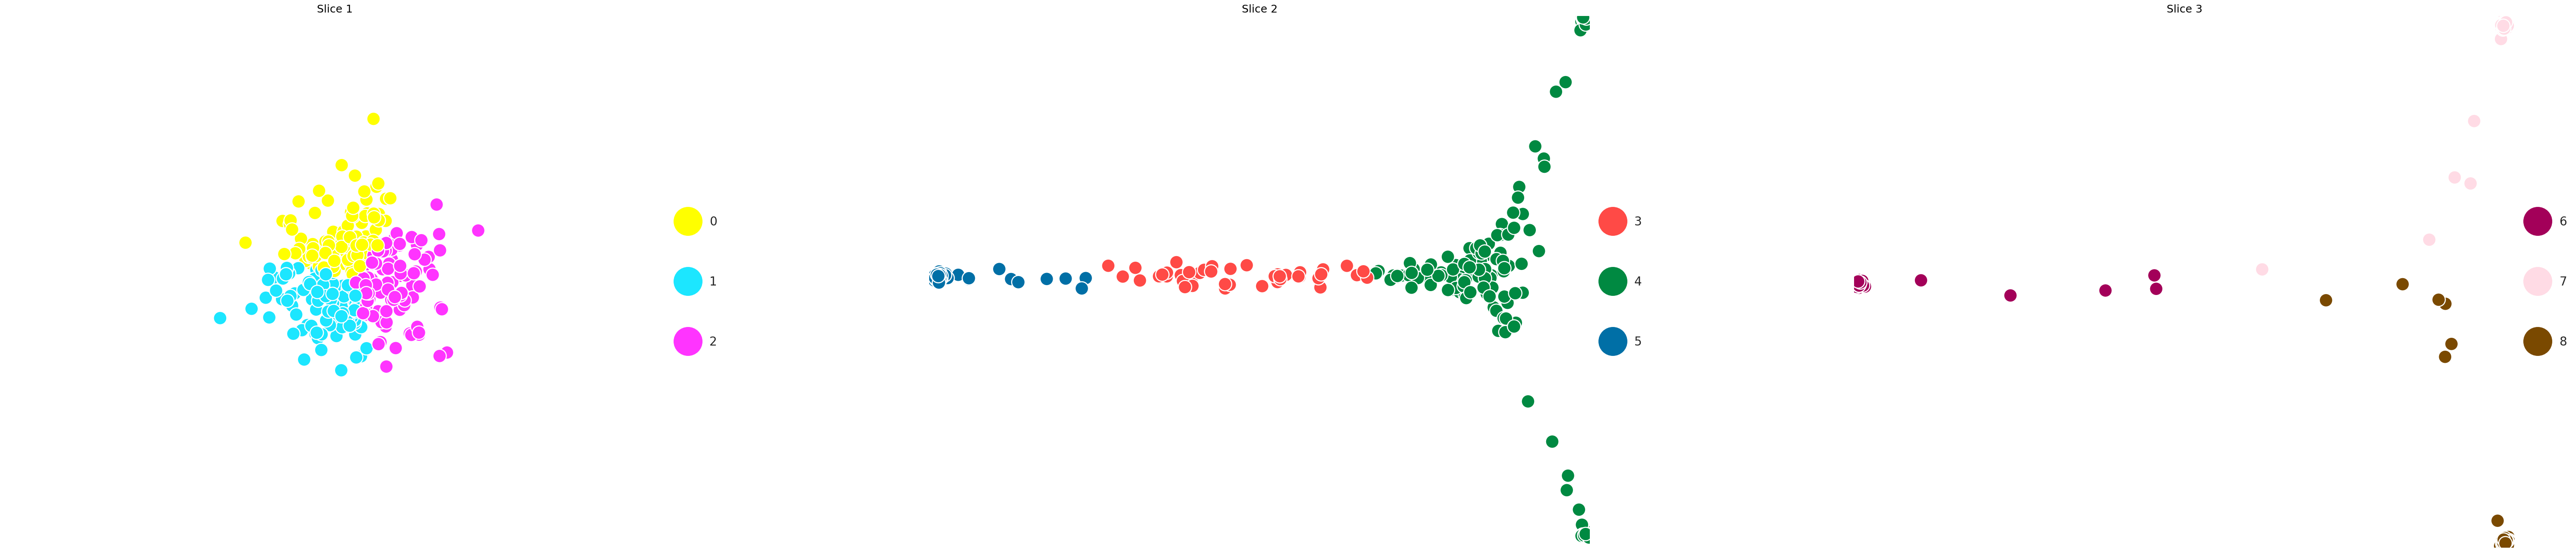

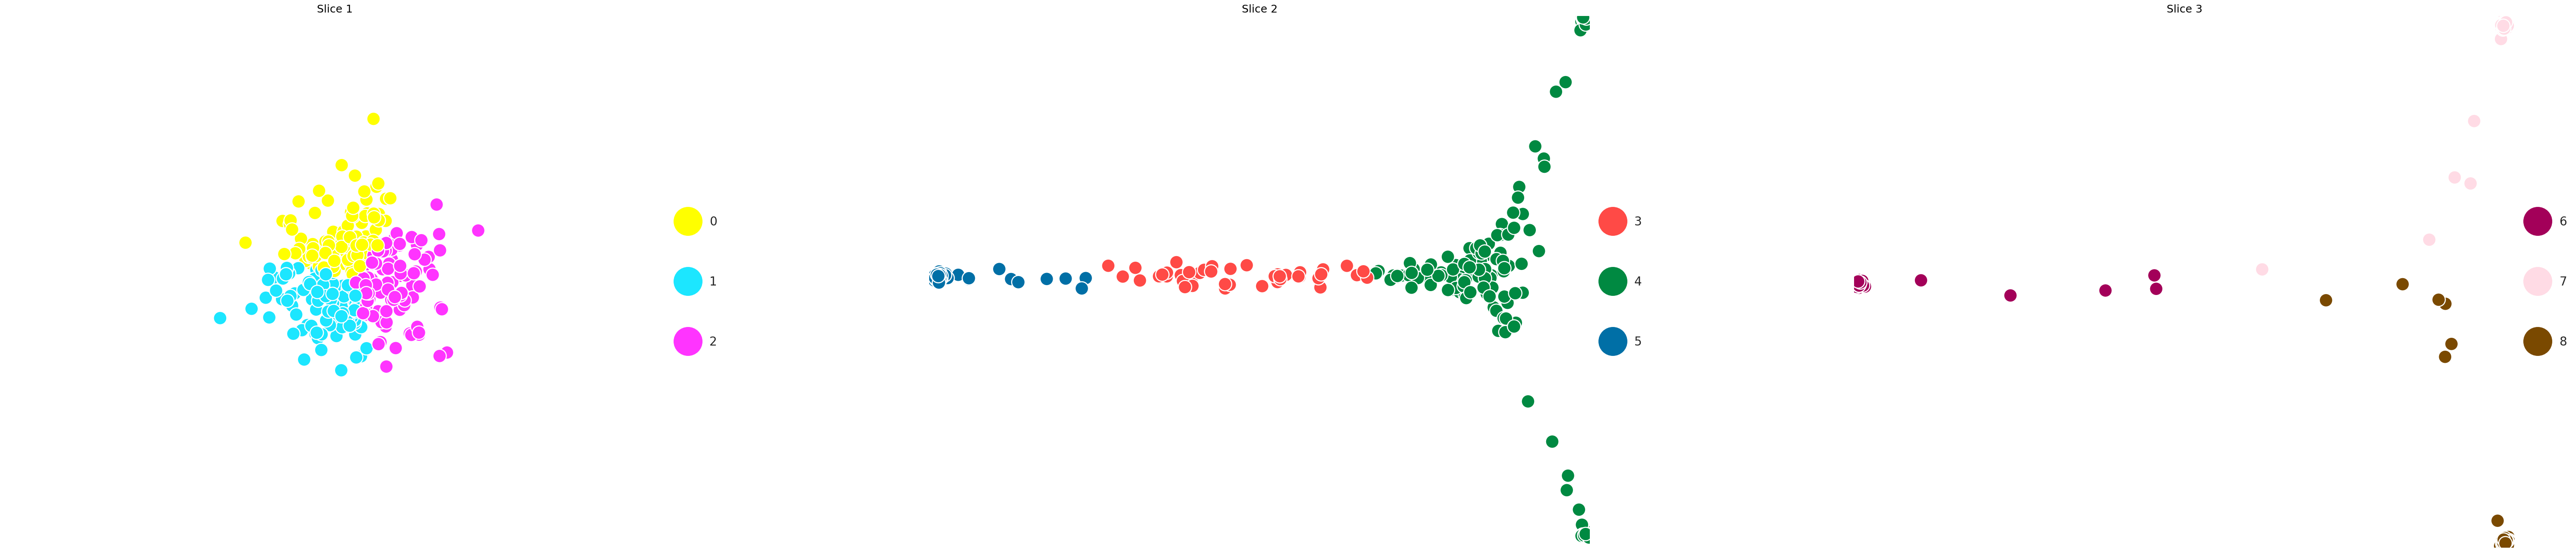

<Figure size 640x480 with 0 Axes>

findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: 

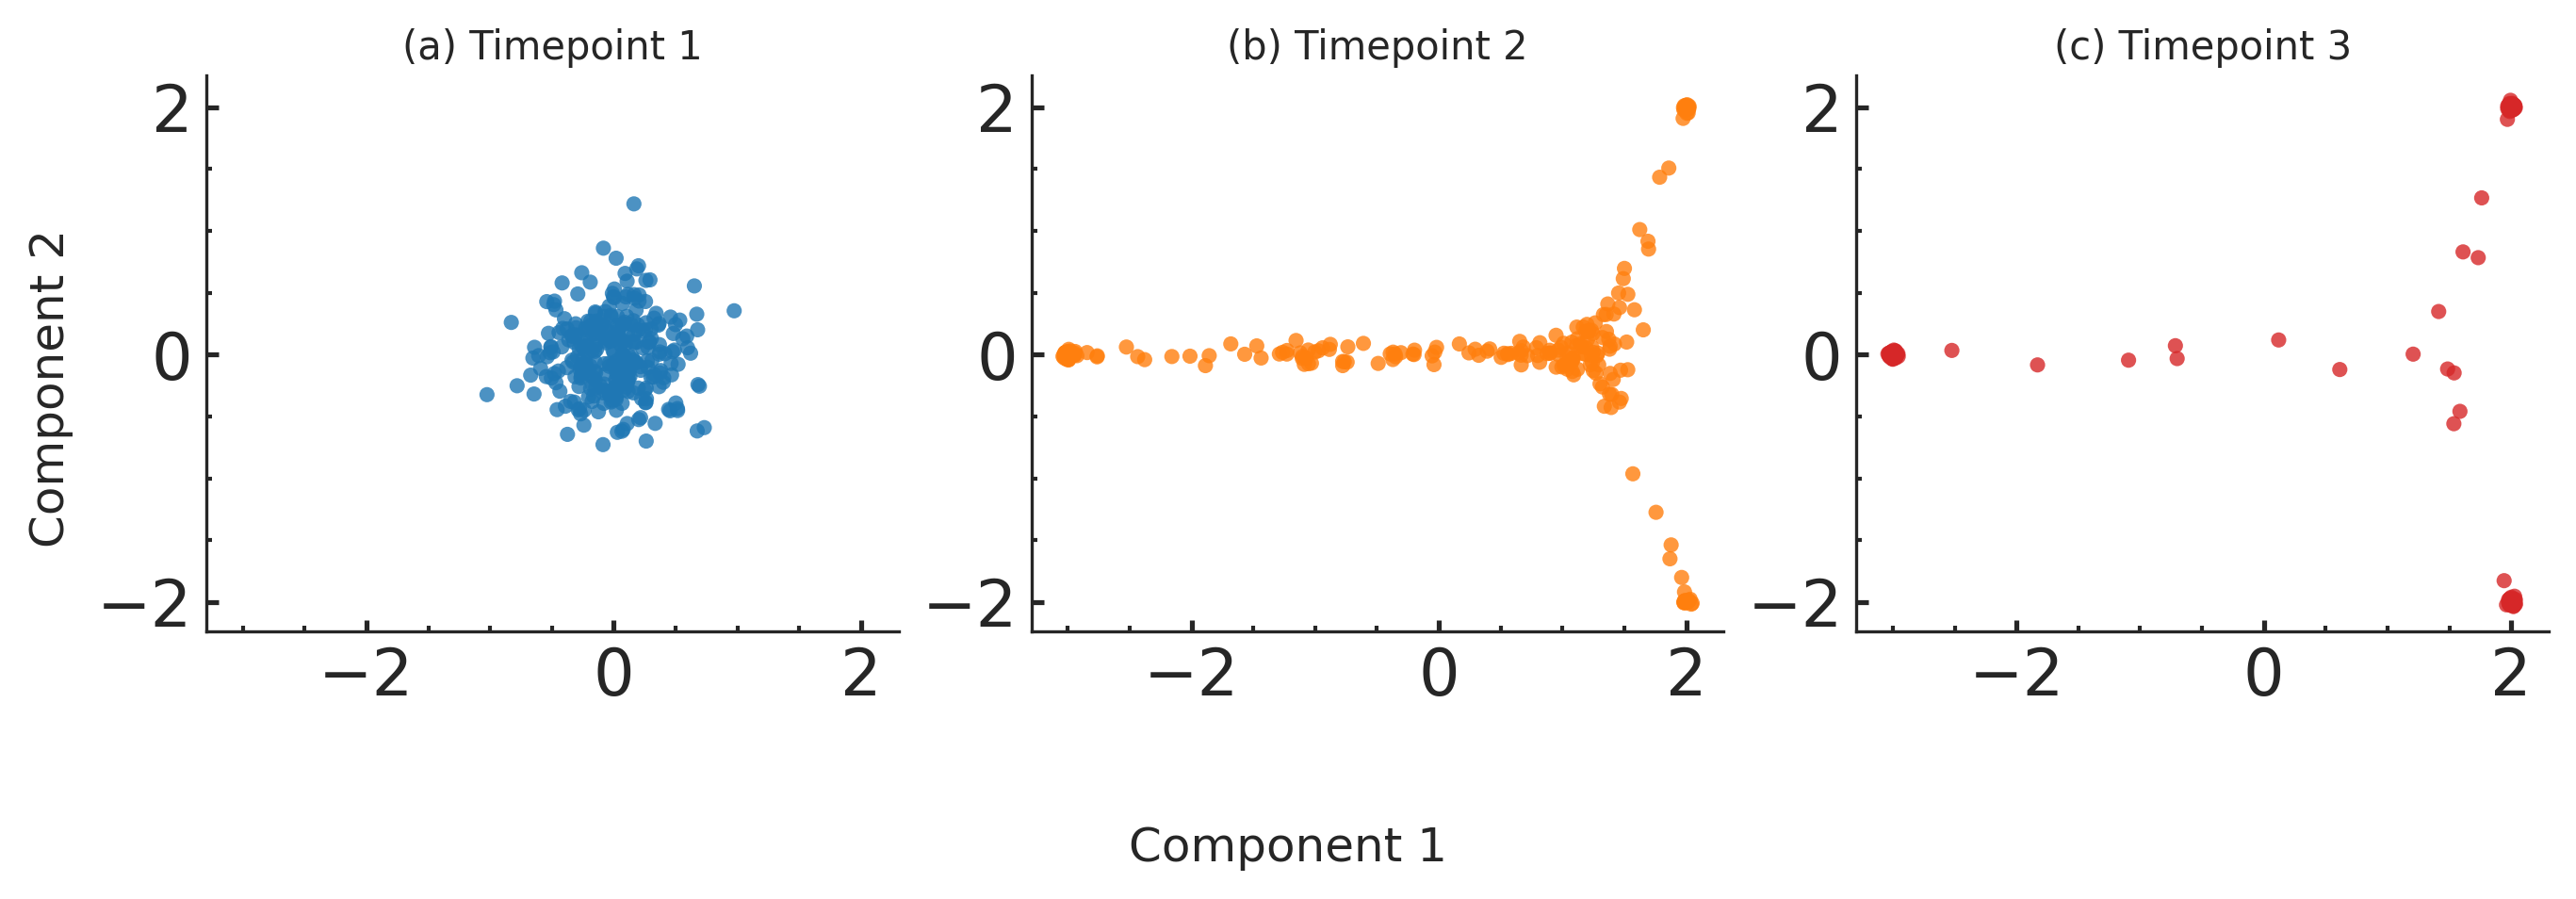

Iteration: 0
Iteration: 25


findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: 

Initial Wasserstein cost: 4.971798896789551, GW-cost: 0, Total cost: 4.971798896789551
Final Wasserstein cost: 4.262818813323975, GW-cost: 0, Total cost: 4.262818813323975


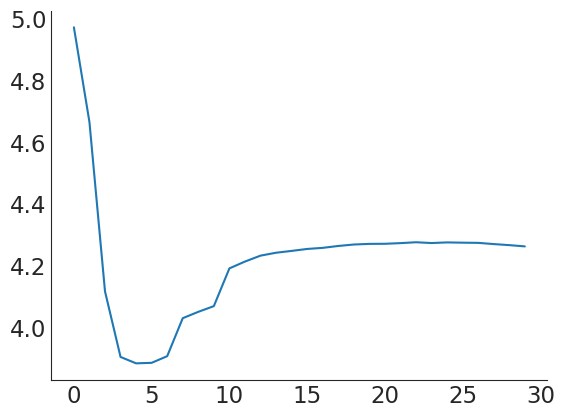

Iteration: 0
Iteration: 25


findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: 

Initial Wasserstein cost: 10.668725967407227, GW-cost: 0, Total cost: 10.668725967407227
Final Wasserstein cost: 4.400774955749512, GW-cost: 0, Total cost: 4.400774955749512


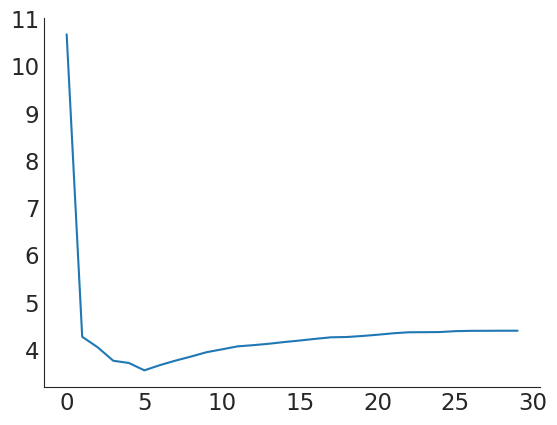

Iteration: 0
Iteration: 25


In [ ]:

import src.validation.trajectory_validation as tv

# 1) Set up device, dtype, and HM-OT hyperparameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float32
dtype_np = np.float32

snap_times    = [0, 200, 399]
noise_levels = [0.002, 0.003, 0.005, 
                0.0075, 0.01, 0.02]

rank_list     = [(3,3)] * (len(snap_times)-1)
iters, gamma, alpha, tau_in = 30, 80.0, 0.0, 10
seed = 42

fracs_hmot = []
fracs_wot = []
fracs_gwot = []

# 2) Loop over noise levels
for i, D in enumerate(noise_levels):
    print(f"\n\n==== D = {D} ====")
    
    # 2a) Simulate Langevin data (no re-plotting here)
    sim = simu.simulate_langevin_tristable(
        D,
        num_traj=300,
        N_steps=400,
        dt=0.02,
        snap_times=tuple(snap_times),
        seed=seed,
        plot_original=True      # suppress the 2D-contour plot here
    )
    data_snap = {f"step_{t}": sim['snapshots'][t] for t in snap_times}
    
    # 2b) Run HM-OT analysis + all plots
    frac_hmot, frac_wot, frac_gwot = tv.analyze_noise_level(
        D              = D,
        data_snap      = data_snap,
        snap_times     = snap_times,
        num_traj       = sim['Xs'].shape[0],
        device         = device,
        dtype          = dtype,
        dtype_np       = dtype_np,
        rank_list      = rank_list,
        iter           = iters,
        gamma          = gamma,
        alpha          = alpha,
        tau_in         = tau_in,
        seed           = seed
    )
    fracs_hmot.append(frac_hmot)
    fracs_wot.append(frac_wot)
    fracs_gwot.append(frac_gwot)



In [ ]:

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5), constrained_layout=True)

plt.plot(noise_levels, fracs_hmot, marker='o', markersize=6, linewidth=2, label='HM‑OT')
plt.plot(noise_levels, fracs_wot,  marker='s', linestyle='--', markersize=6, linewidth=2, label='Waddington‑OT (WOT) Cluster-Supervised')
plt.plot(noise_levels, fracs_gwot, marker='s', linestyle='--', markersize=6, linewidth=2, label='Global Waddington‑OT (gWOT) Cluster-Supervised')

plt.xlabel('Noise $D$', fontsize=13, labelpad=10)
plt.ylabel('Fraction of trajectories correctly aligned', fontsize=13, labelpad=10)
plt.title('Alignment Accuracy vs Noise Level', fontsize=15, fontweight='bold', pad=15)

plt.xticks(noise_levels,
           noise_levels, 
           fontsize=11, 
           rotation=40)

plt.yticks(fontsize=11)
plt.xlim(1.8e-3, 0.021)
plt.ylim(0.2, 0.8)
plt.xscale('log')

plt.legend(frameon=False, fontsize=11, loc='upper left')
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

plt.show()

In [ ]:
fracs_hmot

In [ ]:
fracs_wot

In [ ]:
fracs_gwot

In [ ]:
noise_labels = [f'{lvl:.4f}' for lvl in noise_levels]

fig, ax = plt.subplots(figsize=(8,5), constrained_layout=True)

ax.plot(noise_levels, fracs_hmot,  marker='o', markersize=6, linewidth=2, label='Hidden-Markov OT (HM-OT)')
ax.plot(noise_levels, fracs_wot,   marker='s', linestyle='--', markersize=6, linewidth=2, label='Waddington-OT (WOT)')
ax.plot(noise_levels, fracs_gwot,  marker='^', linestyle='-.', markersize=6, linewidth=2, label='Global Waddington-OT (gWOT)')

ax.set_xlabel('Noise $D$', fontsize=13, labelpad=10)
ax.set_ylabel('Fraction of trajectories correctly aligned', fontsize=13, labelpad=10)
ax.set_title('Alignment Accuracy vs Noise Level', fontsize=15, fontweight='bold', pad=15)

ax.set_xscale('log')
ax.set_xticks(noise_levels)
ax.set_xticklabels(noise_labels, fontsize=11, rotation=40, ha='right')

ax.set_yticks(ax.get_yticks())
ax.tick_params(axis='y', labelsize=11)

ax.set_xlim(1.8e-3, 0.021)
ax.set_ylim(0.2, 0.8)

ax.legend(frameon=False, fontsize=11, loc='center left')
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

plt.show()